# Apple Stock Price Prediction

### Evan Goddard, Hasan Allahyarov, Viktor Spasic, Hongxian Zhang

The main focus on this project is to apply what we have learned from this course to the Apple Stock Price dataset, visualize our findings, and calculate the metrics that have been the most prominent during this course, which are Value at Risk and Expected Shortfall.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import scipy.stats as stats
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('AAPL.csv')

/Users/hasanallahyarov/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1.) Data properties

The following commands below will show the properties of the dataset.


In [2]:
df.shape

(8256, 7)

Here we see that there are no missing values in the dataset. We also see that the Date column is of the object type, the Voume column is of the integer type, and the other 5 columns are of the float type.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8256 entries, 0 to 8255
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      8256 non-null   object 
 1   Open      8256 non-null   float64
 2   High      8256 non-null   float64
 3   Low       8256 non-null   float64
 4   Close     8256 non-null   float64
 5   AdjClose  8256 non-null   float64
 6   Volume    8256 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 451.6+ KB


Here we specifically see that there are no missing values in any column.

In [4]:
df.isna().sum()

Date        0
Open        0
High        0
Low         0
Close       0
AdjClose    0
Volume      0
dtype: int64

From the code below we see some valuable metrics from the dataset such as mean, std, min, percentile values, and max for every numerical column. There is no surprising finding from this, except that the volume has a very large range of values.

In [5]:
df.describe()

,Open,High,Low,Close,AdjClose,Volume
count,8256.000000,8256.000000,8256.000000,8256.000000,8256.000000,8.256000e+03
mean,23.476028,23.701968,23.228526,23.470982,21.462596,9.699490e+07
std,38.644294,38.949541,38.310578,38.639202,36.179215,8.926802e+07
min,0.261161,0.263393,0.258929,0.258929,0.207047,5.992000e+05
25%,1.285156,1.312500,1.258929,1.285714,1.091278,4.058810e+07
50%,1.839286,1.867679,1.803571,1.839286,1.551007,6.832000e+07
75%,26.461427,26.672143,25.947143,26.386785,23.115589,1.197998e+08
max,164.800003,164.940002,163.630005,164.050003,159.741684,1.855410e+09


Finally, below we see the first 5 rows of the dataset, giving an indication of how the observations will look.

In [6]:
df.head()

,Date,Open,High,Low,Close,AdjClose,Volume
0,1/2/1985,0.520089,0.520089,0.497768,0.497768,0.398031,43825600
1,1/3/1985,0.506696,0.520089,0.506696,0.506696,0.405170,41652800
2,1/4/1985,0.506696,0.508929,0.500000,0.506696,0.405170,34316800
3,1/7/1985,0.506696,0.508929,0.504464,0.504464,0.403385,42728000
4,1/8/1985,0.504464,0.508929,0.500000,0.500000,0.399816,35280000


# 2.) Data visualization

Below we see the different variables and how they change through time. We see that all variables follow similar pattern, except the volume column. This column does not show any clear trend.

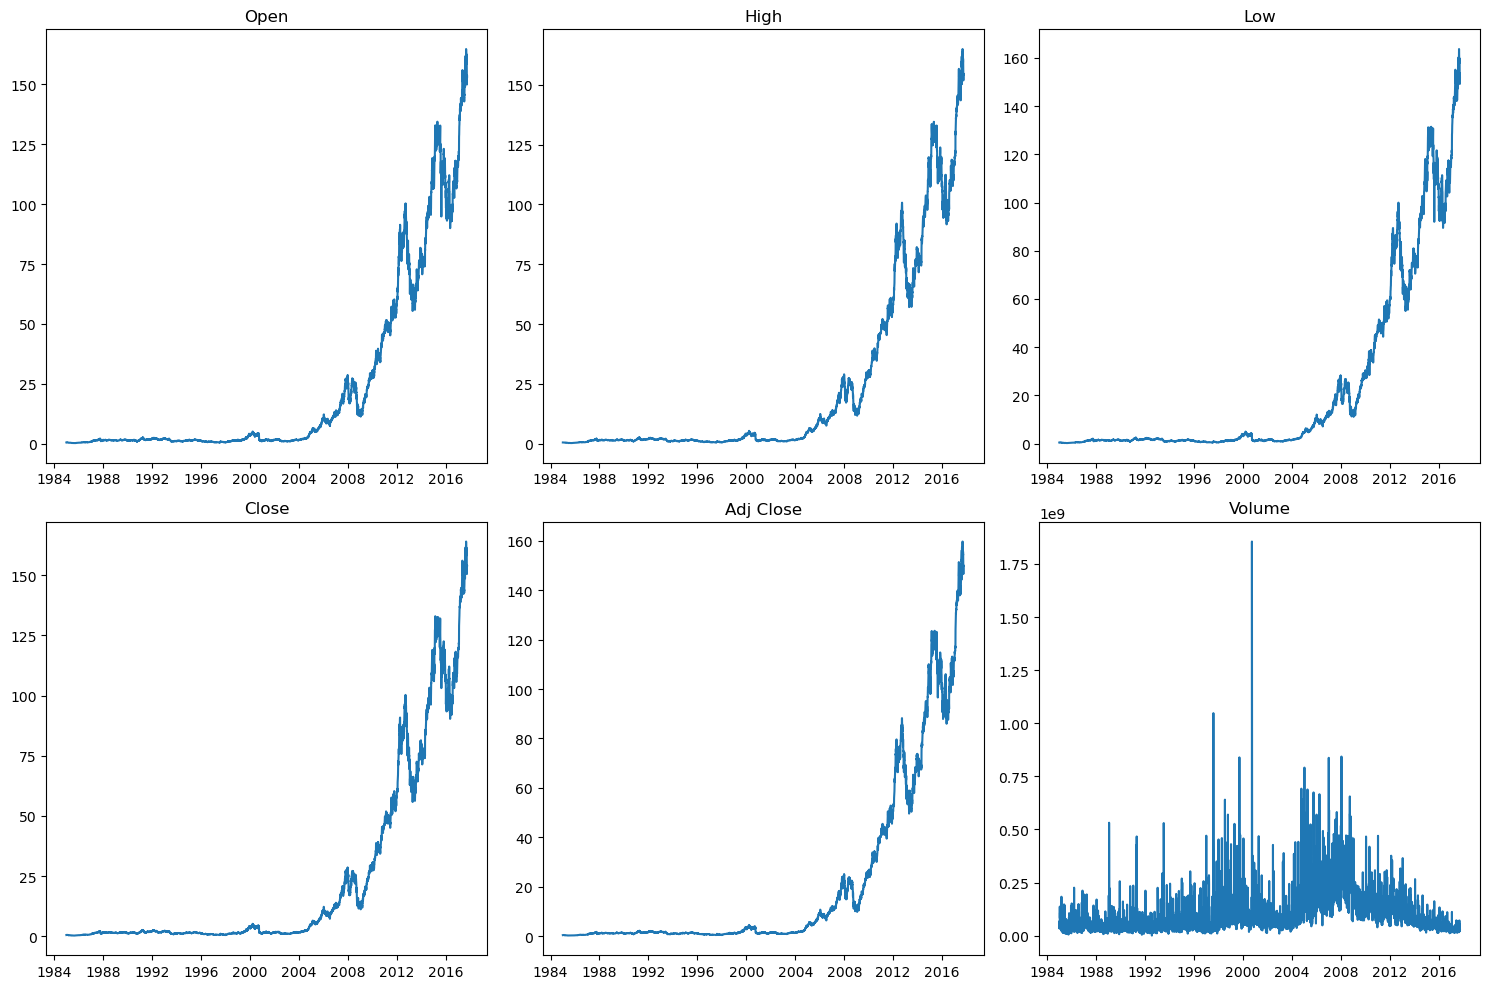

In [7]:
df['Date'] = pd.to_datetime(df['Date'])  

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].plot(df['Date'], df['Open'])
axs[0, 0].set_title('Open')

axs[0, 1].plot(df['Date'], df['High'])
axs[0, 1].set_title('High')

axs[0, 2].plot(df['Date'], df['Low'])
axs[0, 2].set_title('Low')

axs[1, 0].plot(df['Date'], df['Close'])
axs[1, 0].set_title('Close')

axs[1, 1].plot(df['Date'], df['AdjClose'])
axs[1, 1].set_title('Adj Close')

axs[1, 2].plot(df['Date'], df['Volume'])
axs[1, 2].set_title('Volume')

plt.tight_layout()
plt.show()

# 3.) Data Preprocessing

To make the analysis more substantial, we will do some data preprocessing. We will manually add some more time features into the dataset, such as day of week, month, quarter, year, week of year, and day of year. 

In [8]:
def add_features(df):
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['quarter'] = df['Date'].dt.quarter
    df['year'] = df['Date'].dt.year
    df['week_of_year'] = df['Date'].dt.isocalendar().week
    df['day_of_year'] = df['Date'].dt.dayofyear
    return df

df = add_features(df)

Now we see that there are the same amount of observations in the dataset, but more columns/variables.

In [9]:
df.shape

(8256, 13)

Below we calculate the daily returns.

In [10]:
df['Daily Returns'] = (df['AdjClose']-df['AdjClose'].shift(1))/df['AdjClose'].shift(1)
df.head()

,Date,Open,High,Low,Close,AdjClose,Volume,day_of_week,month,quarter,year,week_of_year,day_of_year,Daily Returns
0,1985-01-02,0.520089,0.520089,0.497768,0.497768,0.398031,43825600,2,1,1,1985,1,2,NaN
1,1985-01-03,0.506696,0.520089,0.506696,0.506696,0.405170,41652800,3,1,1,1985,1,3,0.017936
2,1985-01-04,0.506696,0.508929,0.500000,0.506696,0.405170,34316800,4,1,1,1985,1,4,0.000000
3,1985-01-07,0.506696,0.508929,0.504464,0.504464,0.403385,42728000,0,1,1,1985,2,7,-0.004406
4,1985-01-08,0.504464,0.508929,0.500000,0.500000,0.399816,35280000,1,1,1,1985,2,8,-0.008848


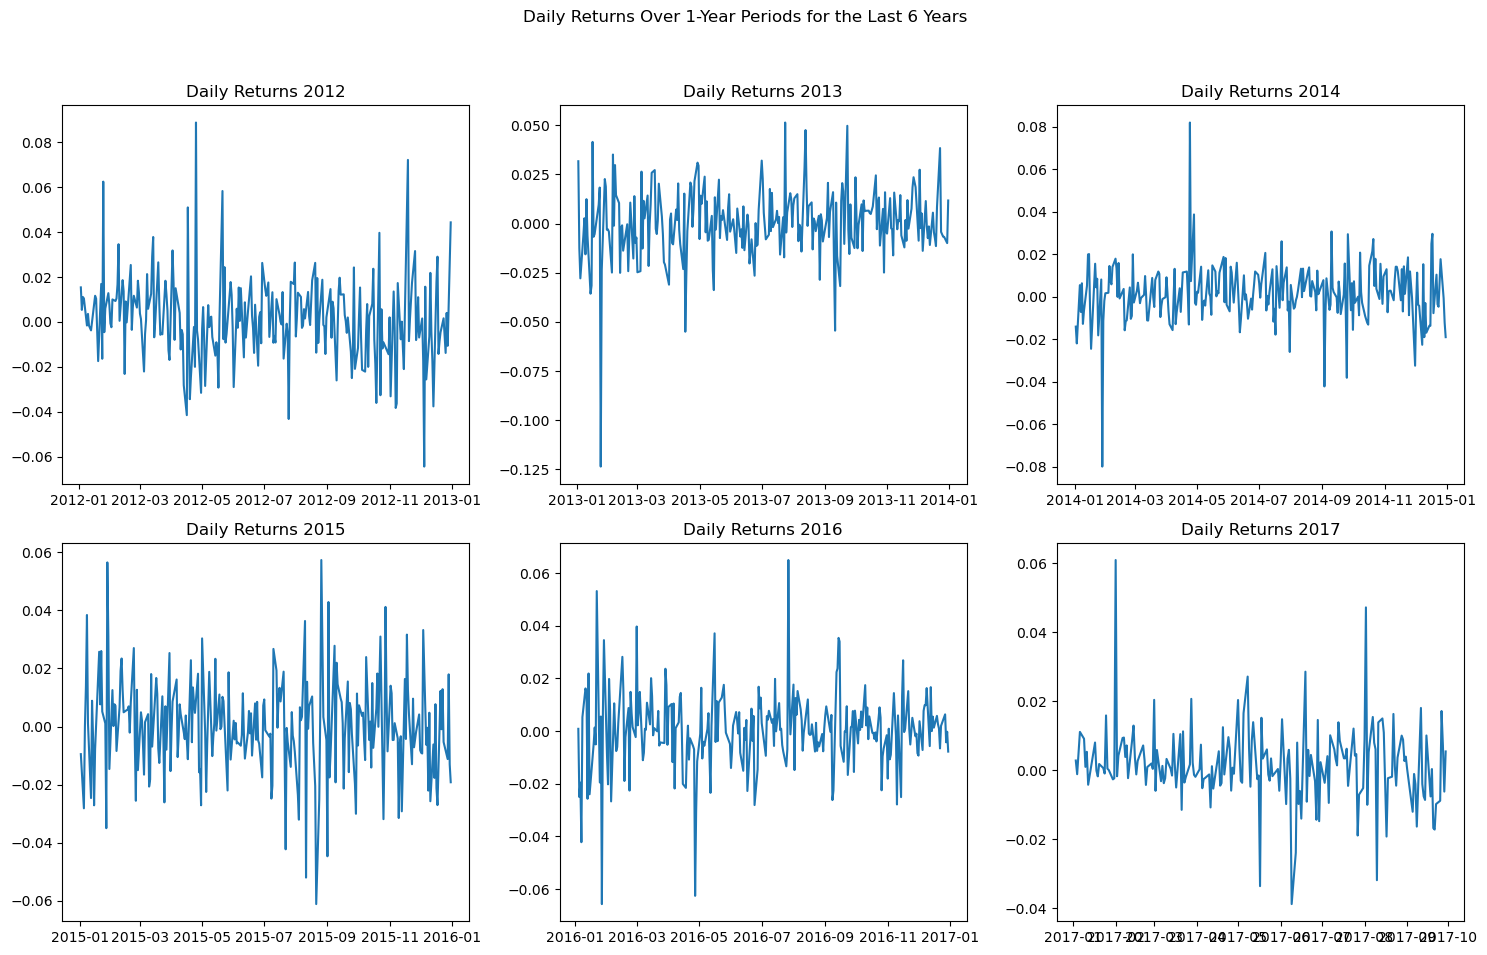

In [11]:
end_year = df['Date'].dt.year.max()
start_year = end_year - 5

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Daily Returns Over 1-Year Periods for the Last 6 Years')

for i in range(6):
    year = start_year + i
    year_data = df[(df['Date'].dt.year == year)]

    ax = axs[i // 3, i % 3]
    
    ax.plot(year_data['Date'], year_data['Daily Returns'])
    ax.set_title(f'Daily Returns {year}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

There does not seem to be a pattern when looking over the last five years to see trends in monthly returns. Next we look at this as monthly charts for the entire dataset

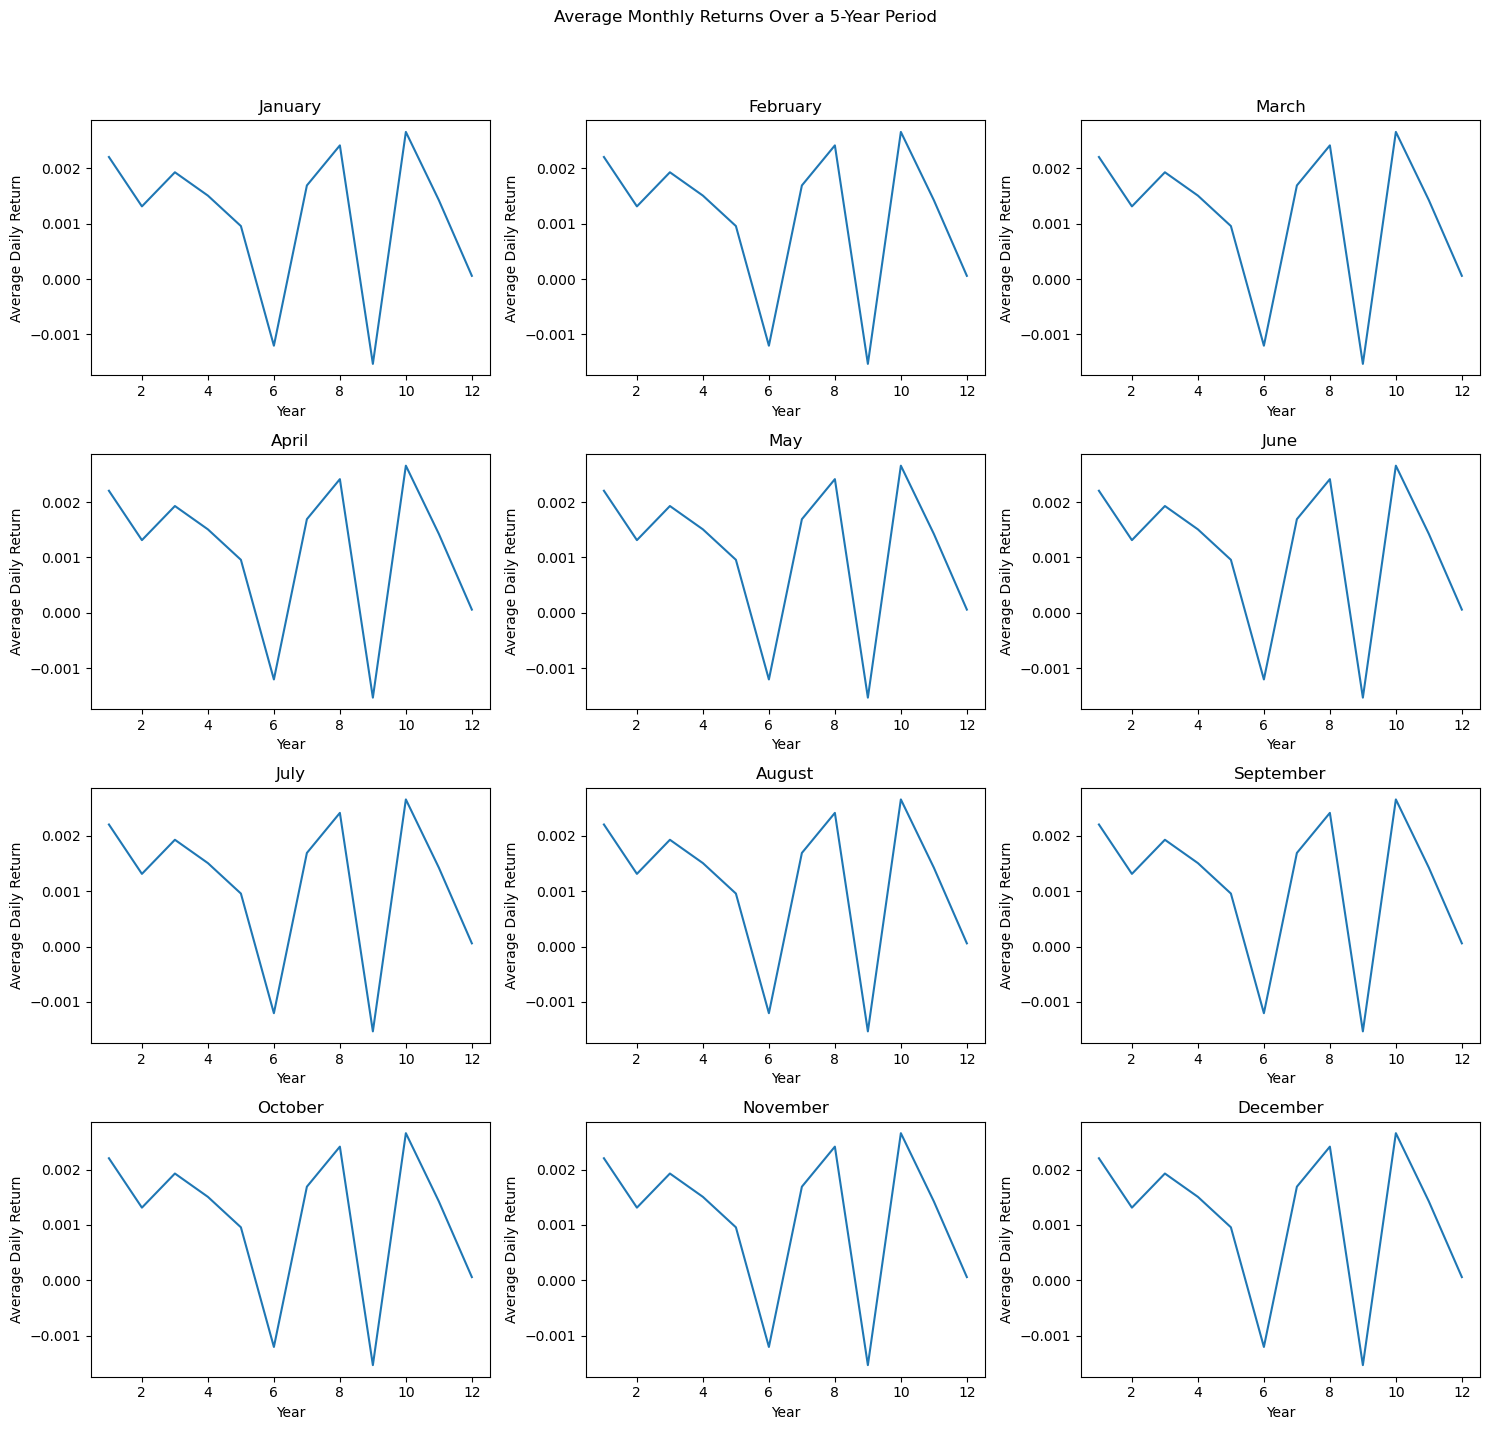

In [12]:
monthly_avg = df.groupby(['year', 'month'])['Daily Returns'].mean().reset_index()

monthly_avg_5yr = monthly_avg.groupby('month')['Daily Returns'].mean()

fig, axs = plt.subplots(4, 3, figsize=(15, 15)) 
fig.suptitle('Average Monthly Returns Over a 5-Year Period')

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for i, month in enumerate(months):
    ax = axs[i // 3, i % 3]

    ax.plot(monthly_avg_5yr.index, monthly_avg_5yr.values)
    ax.set_title(month)
    ax.set_xlabel('Year')
    ax.set_ylabel('Average Daily Return')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

There seems to be more of a correlation between year than there is between month in returns. We decide then to opt to cluster by years instead of by month.

# 4.) K-means clustering

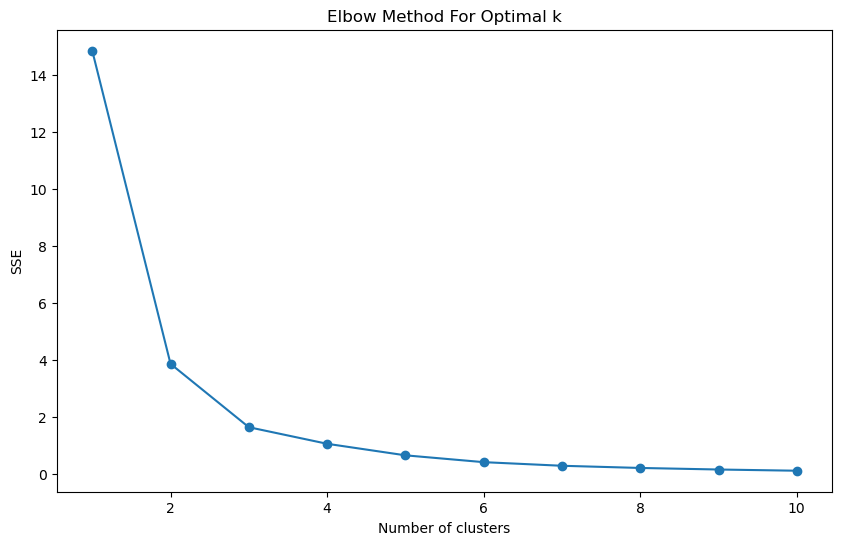

[14.842089754373593,
 3.857676249365861,
 1.6354439931783,
 1.0540029559964594,
 0.649194753916051,
 0.4095104581318574,
 0.2826792248040013,
 0.20614190397219095,
 0.15156303748028938,
 0.1090202056049176]

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

df['year'] = df['Date'].dt.year
annual_prices = df.groupby('year')['AdjClose'].agg(['first', 'last'])
annual_returns = (annual_prices['last'] - annual_prices['first']) / annual_prices['first']

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(annual_returns.values.reshape(-1, 1))
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

sse

Now we will apply K-means clustering with k=3.

In [14]:
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(annual_returns.values.reshape(-1, 1))

annual_returns_clusters = annual_returns.to_frame(name='Annual Returns')
annual_returns_clusters['Cluster'] = clusters

clustered_years = annual_returns_clusters.groupby('Cluster')['Annual Returns'].apply(list)
clustered_years = clustered_years.apply(lambda x: [round(y, 4) for y in x])  # rounding for better readability

cluster_means = annual_returns_clusters.groupby('Cluster')['Annual Returns'].mean()
sorted_clusters = cluster_means.sort_values().index

sorted_clustered_years = clustered_years.loc[sorted_clusters]
sorted_clustered_years

Cluster
0    [-0.2108, -0.0929, -0.1184, -0.4917, -0.1599, ...
1    [0.8202, 0.1687, 0.3081, 0.013, 0.3239, 0.4723...
2    [1.0653, 1.5192, 1.4924, 2.0263, 1.2718, 1.363...
Name: Annual Returns, dtype: object

In [15]:
clustered_years_dict = {cluster: list(annual_returns_clusters[annual_returns_clusters['Cluster'] == cluster].index)
                        for cluster in sorted_clusters}

clustered_years_dict

{0: [1985, 1988, 1989, 1993, 1995, 1996, 1997, 2000, 2002, 2008, 2015],
 1: [1986,
  1990,
  1991,
  1992,
  1994,
  2001,
  2003,
  2006,
  2010,
  2011,
  2012,
  2013,
  2014,
  2016,
  2017],
 2: [1987, 1998, 1999, 2004, 2005, 2007, 2009]}

In [16]:
clustered_years_df = pd.DataFrame(
    [(cluster, ", ".join(map(str, years))) for cluster, years in clustered_years_dict.items()],
    columns=['Cluster', 'Years'])

clustered_years_df.set_index('Cluster', inplace=True)

cluster_rename = {2: "Negative/Low Positive Returns",
                  0: "Moderate Positive Returns",
                  1: "Highest Positive Returns"}

clustered_years_df.rename(index=cluster_rename, inplace=True)
clustered_years_df

,Years
Cluster,
Moderate Positive Returns,"1985, 1988, 1989, 1993, 1995, 1996, 1997, 2000..."
Highest Positive Returns,"1986, 1990, 1991, 1992, 1994, 2001, 2003, 2006..."
Negative/Low Positive Returns,"1987, 1998, 1999, 2004, 2005, 2007, 2009"


In [17]:
df['cluster'] = np.nan
for i in df.index:
    x = df['year'].loc[i]
    for key, values in clustered_years_dict.items():
        if x in values:
            y = key
            break
    df['cluster'].loc[i] = y   

## Create dictionary of years to sort yearly returns for later sensitivity analysis

The next step is to create a holdout test set, separated from the training and validation splits that will be conducted. If this holdout test set got excluded, we would be also be using the various test samples, which is a little bit like training on test data. The test samples would not really be clean and would therefore not be reliable estimates of the results.

To create a holdout test set for evaluating models, while keeping the data chronological within each cluster, we will divide each cluster into two parts: 80% for training and validation, and 20% for the holdout test set. This approach ensures that the test set remains 'clean'.

In [18]:
clustered_dfs = {cluster: df[df['year'].isin(years)] for cluster, years in clustered_years_dict.items()}

train_val_test_split = {}
for cluster, cluster_df in clustered_dfs.items():
    split_index = int(len(cluster_df) * 0.8)
    train_val_df = cluster_df.iloc[:split_index]
    test_df = cluster_df.iloc[split_index:]
    train_val_test_split[cluster] = (train_val_df, test_df)

cluster_rename = {2: "Negative/Low Positive Returns",
                  0: "Moderate Positive Returns",
                  1: "Highest Positive Returns"}

split_info = {}
for cluster, (train_val_df, test_df) in train_val_test_split.items():
    cluster_name = cluster_rename[cluster]
    split_info[cluster_name] = {
        'Train/Validation Set': train_val_df.shape,
        'Test Set': test_df.shape}

split_info

{'Moderate Positive Returns': {'Train/Validation Set': (2222, 15),
  'Test Set': (556, 15)},
 'Highest Positive Returns': {'Train/Validation Set': (2971, 15),
  'Test Set': (743, 15)},
 'Negative/Low Positive Returns': {'Train/Validation Set': (1411, 15),
  'Test Set': (353, 15)}}

# 5.) Moving Average of Each Cluster

Now we will create three different moving averages for each cluster: 60-day moving average, 120-day moving average, and 360-day moving average.

In [19]:
unique_clusters = df['cluster'].unique()

cluster_dfs = {}

for cluster in unique_clusters:
    cluster_dfs[cluster] = df[df['cluster'] == cluster]

Now we have the three data frames (0: Moderate Positive Returns, 1: Highest Positive Returns, 2: Negative/Low Positive Returns).

In [20]:
df_cluster_2 = df[df['cluster'] == unique_clusters[0]]
df_cluster_0 = df[df['cluster'] == unique_clusters[1]]
df_cluster_1 = df[df['cluster'] == unique_clusters[2]]

Adding index column.

In [21]:
df_cluster_2 = df_cluster_2.reset_index()
df_cluster_0 = df_cluster_0.reset_index()
df_cluster_1 = df_cluster_1.reset_index()

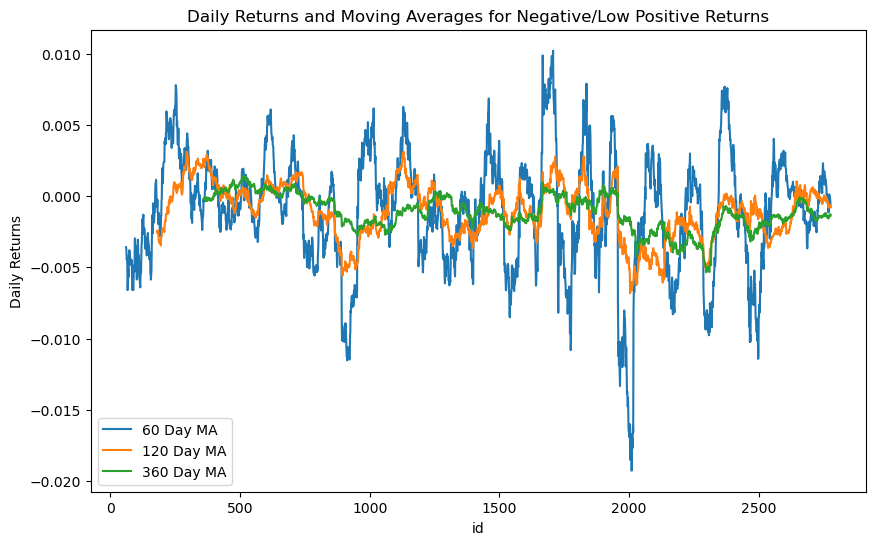

In [22]:
shortMA = 60
midMA = 180
longMA = 360

# 60-day moving average
roll_win60 = df_cluster_2['Daily Returns'].rolling(window=shortMA, win_type="boxcar")
low_roll60 = roll_win60.mean()

# 120-day moving average
roll_win120 = df_cluster_2['Daily Returns'].rolling(window=midMA, win_type="boxcar")
low_roll120 = roll_win120.mean()

# 30-day moving average
roll_win360 = df_cluster_2['Daily Returns'].rolling(window=longMA, win_type="boxcar")
low_roll360 = roll_win360.mean()

plt.figure(figsize=(10, 6))
plt.plot(low_roll60, label='60 Day MA')
plt.plot(low_roll120, label='120 Day MA')
plt.plot(low_roll360, label='360 Day MA')
plt.title('Daily Returns and Moving Averages for Negative/Low Positive Returns')
plt.xlabel('id')
plt.ylabel('Daily Returns')
plt.legend()
plt.show()

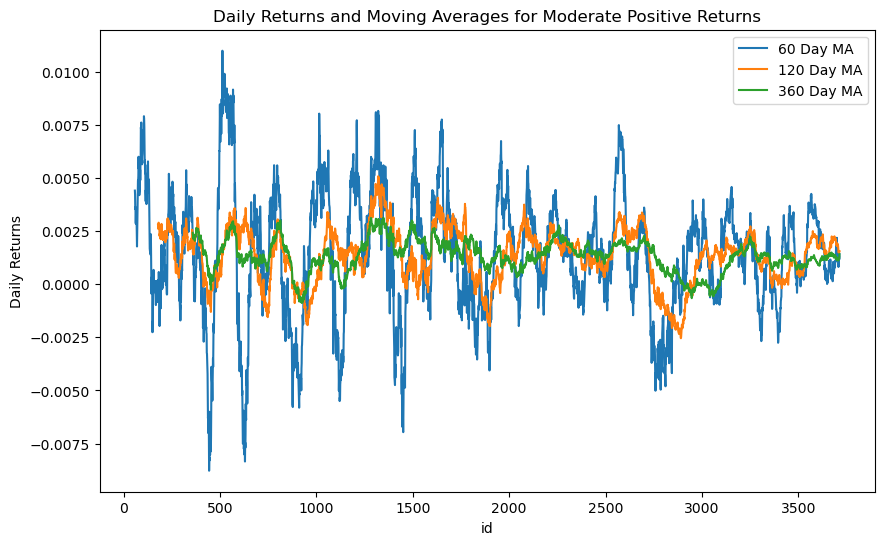

In [23]:
# 60-day moving average
roll_win60 = df_cluster_0['Daily Returns'].rolling(window=shortMA, win_type="boxcar")
mod_roll60 = roll_win60.mean()

# 120-day moving average
roll_win120 = df_cluster_0['Daily Returns'].rolling(window=midMA, win_type="boxcar")
mod_roll120 = roll_win120.mean()

# 360-day moving average
roll_win360 = df_cluster_0['Daily Returns'].rolling(window=longMA, win_type="boxcar")
mod_roll360 = roll_win360.mean()

plt.figure(figsize=(10, 6))
plt.plot(mod_roll60, label='60 Day MA')
plt.plot(mod_roll120, label='120 Day MA')
plt.plot(mod_roll360, label='360 Day MA')
plt.title('Daily Returns and Moving Averages for Moderate Positive Returns')
plt.xlabel('id')
plt.ylabel('Daily Returns')
plt.legend()
plt.show()

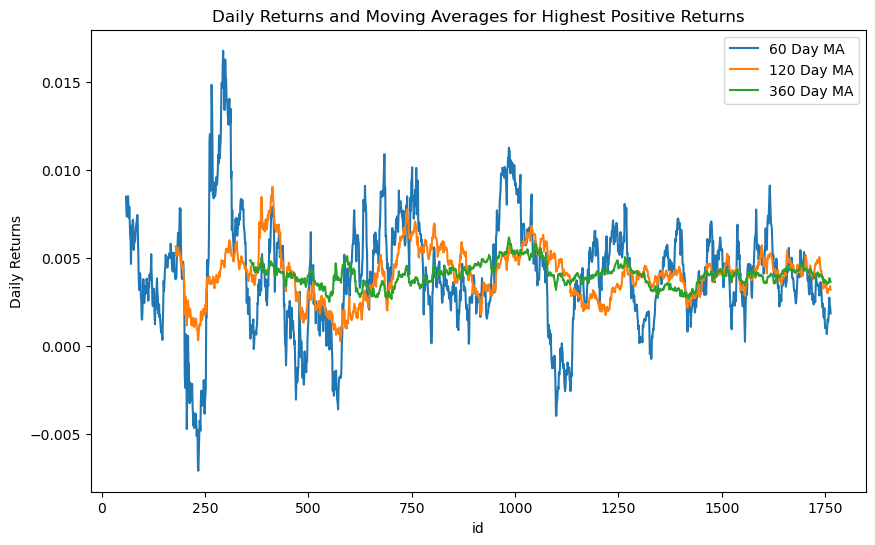

In [24]:
# 60-day moving average
roll_win60 = df_cluster_1['Daily Returns'].rolling(window=shortMA, win_type="boxcar")
high_roll60 = roll_win60.mean()

# 120-day moving average
roll_win120 = df_cluster_1['Daily Returns'].rolling(window=midMA, win_type="boxcar")
high_roll120 = roll_win120.mean()

# 360-day moving average
roll_win360 = df_cluster_1['Daily Returns'].rolling(window=longMA, win_type="boxcar")
high_roll360 = roll_win360.mean()

plt.figure(figsize=(10, 6))
plt.plot(high_roll60, label='60 Day MA')
plt.plot(high_roll120, label='120 Day MA')
plt.plot(high_roll360, label='360 Day MA')
plt.title('Daily Returns and Moving Averages for Highest Positive Returns')
plt.xlabel('id')
plt.ylabel('Daily Returns')
plt.legend()
plt.show()

The id indicates observations of daily returns for each year that falls in each cluster chronologically. From here we can do a sensetivity analysis when predicting VaR and Expected Shortfall.

# 6.) Latest 360 data points for the three different clusters

## Negative/Low Positive Returns

In [25]:
id_column = range(len(low_roll60))

new_df = pd.DataFrame({
    'id': id_column,
    'vals': low_roll60
})

print(new_df.tail())

        id      vals
2773  2773 -0.000155
2774  2774 -0.000233
2775  2775 -0.000055
2776  2776 -0.000333
2777  2777 -0.000733


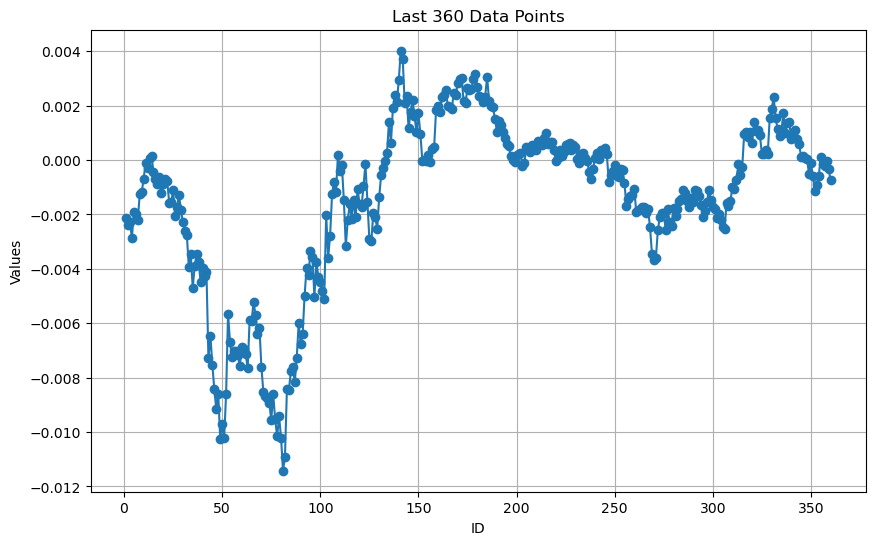

In [26]:
last_360_points = new_df.tail(360)

last_360_points['id'] = range(1, 361)

plt.figure(figsize=(10, 6))
plt.plot(last_360_points['id'], last_360_points['vals'], marker='o', linestyle='-')
plt.title('Last 360 Data Points')
plt.xlabel('ID')
plt.ylabel('Values')
plt.grid(True)
plt.show()

#

## Moderate Positive Returns

In [27]:
id_column = range(len(mod_roll60))

new_df = pd.DataFrame({
    'id': id_column,
    'vals': mod_roll60
})

print(new_df.tail())

        id      vals
3709  3709  0.000913
3710  3710  0.001160
3711  3711  0.001339
3712  3712  0.001167
3713  3713  0.001416


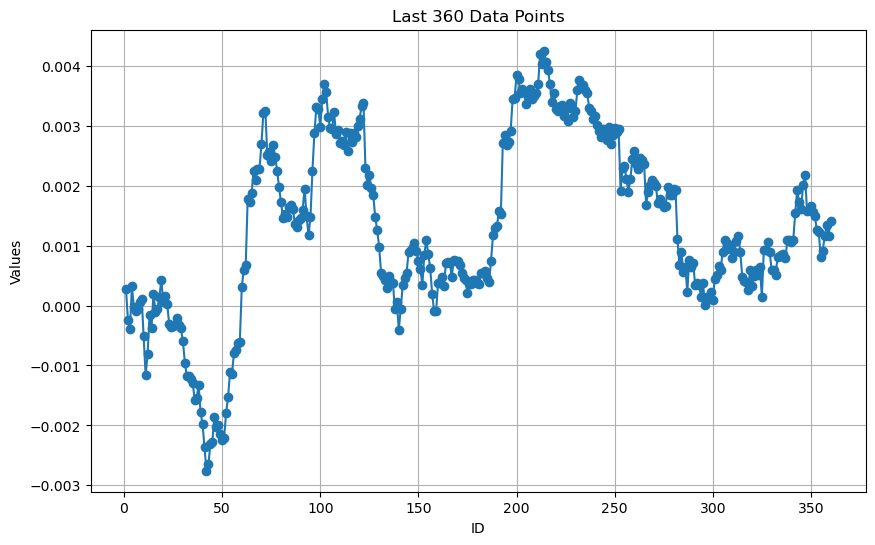

In [28]:
last_360_points = new_df.tail(360)

last_360_points['id'] = range(1, 361)

plt.figure(figsize=(10, 6))
plt.plot(last_360_points['id'], last_360_points['vals'], marker='o', linestyle='-')
plt.title('Last 360 Data Points')
plt.xlabel('ID')
plt.ylabel('Values')
plt.grid(True)
plt.show()

## Highest Positive Returns

In [29]:
id_column = range(len(high_roll60))

new_df = pd.DataFrame({
    'id': id_column,
    'vals': high_roll60
})

print(new_df.tail())

        id      vals
1759  1759  0.002155
1760  1760  0.002763
1761  1761  0.002193
1762  1762  0.002295
1763  1763  0.001866


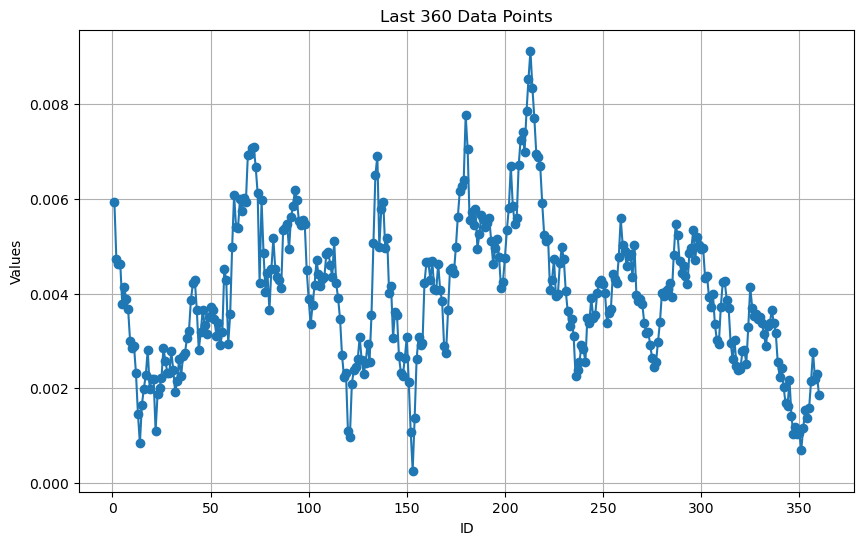

In [30]:
last_360_points = new_df.tail(360)

last_360_points['id'] = range(1, 361)

plt.figure(figsize=(10, 6))
plt.plot(last_360_points['id'], last_360_points['vals'], marker='o', linestyle='-')
plt.title('Last 360 Data Points')
plt.xlabel('ID')
plt.ylabel('Values')
plt.grid(True)
plt.show()

# 7.) Sensitivity Analysis: Calculating the 0.05 VaR and Expected Shortfall

First we will define two functions to calculate Value at Risk and Expected Shortfall:
1. Monte Carlo
2. Bootstrap

In [31]:
def monte_carlo_var_es(data, alpha=0.05, iterations=10000):
    mean, std = norm.fit(data.dropna())
    simulated_returns = norm.rvs(mean, std, size=iterations)
    VaR = np.percentile(simulated_returns, alpha * 100)
    ES = simulated_returns[simulated_returns <= VaR].mean()
    return VaR, ES


def bootstrap_var_es(data, alpha=0.05, iterations=10000):
    clean_data = data.dropna()
    bootstrap_samples = np.random.choice(clean_data, (len(clean_data), iterations), replace=True)
    sorted_samples = np.sort(bootstrap_samples, axis=0)
    VaR = np.percentile(sorted_samples, alpha * 100, axis=0).mean()
    ES_samples = sorted_samples[sorted_samples <= VaR]
    ES = np.mean(ES_samples, axis=0) if ES_samples.size > 0 else np.nan
    return VaR, ES

### 1.) Monte Carlo

In [33]:
VaR_cluster_2_mc, ES_cluster_2_mc = monte_carlo_var_es(low_roll60)
VaR_cluster_0_mc, ES_cluster_0_mc = monte_carlo_var_es(mod_roll60)
VaR_cluster_1_mc, ES_cluster_1_mc = monte_carlo_var_es(high_roll60)

monte_carlo_results = pd.DataFrame({
    'Cluster': ['Negative/Low Positive Returns', 'Moderate Positive Returns', 'Highest Positive Returns'],
    'VaR (0.05)': [-VaR_cluster_2_mc, -VaR_cluster_0_mc, -VaR_cluster_1_mc],
    'ES (0.05)': [-ES_cluster_2_mc, -ES_cluster_0_mc, -ES_cluster_1_mc]
})

monte_carlo_results

,Cluster,VaR (0.05),ES (0.05)
0,Negative/Low Positive Returns,0.007891,0.009667
1,Moderate Positive Returns,0.003289,0.004523
2,Highest Positive Returns,0.001257,0.002628


### 2.) Bootstrap

In [35]:
VaR_cluster_2_bs, ES_cluster_2_bs = bootstrap_var_es(low_roll60)
VaR_cluster_0_bs, ES_cluster_0_bs = bootstrap_var_es(mod_roll60)
VaR_cluster_1_bs, ES_cluster_1_bs = bootstrap_var_es(high_roll60)

bootstrap_results = pd.DataFrame({
    'Cluster': ['Negative/Low Positive Returns', 'Moderate Positive Returns', 'Highest Positive Returns'],
    'VaR (0.05)': [-VaR_cluster_2_bs, -VaR_cluster_0_bs, -VaR_cluster_1_bs],
    'ES (0.05)': [-ES_cluster_2_bs, -ES_cluster_0_bs, -ES_cluster_1_bs]
})

bootstrap_results

,Cluster,VaR (0.05),ES (0.05)
0,Negative/Low Positive Returns,0.008383,0.011206
1,Moderate Positive Returns,0.003651,0.004993
2,Highest Positive Returns,0.001701,0.003060
